# IMPORTS

In [1]:
import torch
import torch.nn as nn
import os
import torch.utils.data as data_utils

import numpy as np
import torch.nn.functional as F
import math, copy, time
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

%matplotlib inline  

Note: The file assumes the presence of CUDA

# Helper Functions

In [2]:
def lines_to_np_array(lines):
    return np.array([[int(i) for i in line.split()] for line in lines])

def get_data_loader(dataset_location, batch_size):  
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        
        with open(filepath) as f:
            lines = f.readlines()
        
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
        
    return splitdata

train_loader, valid_loader, test_loader = get_data_loader("./data", 64)

# Classes

In [3]:
#https://github.com/pytorch/pytorch/issues/2118
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [4]:
from torch.distributions.normal import Normal

class VAE(nn.Module):
    def __init__(self, hidden_size, n_latent_vars):
        super(VAE, self).__init__()
        self.n_latent_vars = n_latent_vars
        self.hidden_size = hidden_size
        
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
                                     nn.ReLU(),
                                     nn.AvgPool2d(kernel_size=2, stride=2),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
                                     nn.ReLU(),
                                     nn.AvgPool2d(kernel_size=2, stride=2),
                                     nn.Conv2d(in_channels=64, out_channels=hidden_size, kernel_size=(3, 3)),
                                     nn.ReLU(),
                                     Flatten(),
                                     nn.Linear(hidden_size*3*3, hidden_size),
                                     nn.Linear(hidden_size, n_latent_vars*2)
                                    )
        
        self.decoder_linear = nn.Linear(n_latent_vars, hidden_size)
        
        self.decoder = nn.Sequential(
                                     nn.ReLU(),
                                     nn.Conv2d(hidden_size, 64, kernel_size=(5, 5), padding=(4, 4)),
                                     nn.ReLU(),
                                     nn.UpsamplingBilinear2d(scale_factor=2),
                                     nn.Conv2d(64, 32, kernel_size=(3, 3), padding=(2, 2)),
                                     nn.ReLU(),
                                     nn.UpsamplingBilinear2d(scale_factor=2),
                                     nn.Conv2d(32, 16, kernel_size=(3, 3), padding=(2, 2)),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 1, kernel_size=(3, 3), padding=(2, 2)),
                                     nn.Sigmoid()
                                    )
        
    
    
    def reparametrization_trick(self, mean, sigma, current_batch_size, k=1, debug=False):
        """
        reparametrize + sample k times
        """
        #https://chinweihuang.files.wordpress.com/2019/04/vae_lecture_2019_full.pdf
        sigma = torch.exp(0.5*sigma) + 1e-7
        epsilon = torch.randn(k, current_batch_size, self.n_latent_vars).to('cuda')
        z = mean + (sigma * epsilon)
        
        return z
    
        
    def forward(self, X, k=1, debug=False):
        """
        Move the X through the iwae: 
        (conv_encoder --> split mean & log sigma --> sample + reparametrization trick --> decoder)
        """
        current_batch_size = X.size()[0]
        
        latent = self.encoder(X)
        
        #note: [None, ...]  adds an extra dimension in the beginning
        mean = latent[:, :self.n_latent_vars][None, ...]
        log_sigma = latent[:, self.n_latent_vars:][None, ...]
        
        z = self.reparametrization_trick(mean, log_sigma, current_batch_size, k)
        
        lin = self.decoder_linear(z)
        
        x_reconstruction = self.decoder(lin.view(current_batch_size*k, self.hidden_size, 1, 1))
        
        return x_reconstruction.view(k, current_batch_size, 28, 28), z, mean, log_sigma
    
    def compute_iwae_loss(self, x, x_reconstruction, z, mu, logvar):            
        """
        http://bjlkeng.github.io/posts/a-variational-autoencoder-on-the-svnh-dataset/
        """
        k = x_reconstruction.size()[0]
        current_batch_size = x_reconstruction.size()[1]
        
        #Remove the channel
        x =  x.view(-1, 28, 28).repeat(k,1,1,1).view(k, current_batch_size, 28*28)
        x_reconstruction = x_reconstruction.view(k, current_batch_size, 28*28) 
        
        #adding the last relu in encoder resulted to NaNs sometimes, so we added +1e-7
        logpx = (x*torch.log(x_reconstruction+1e-7)) + ((1-x)*torch.log(1-x_reconstruction+1e-7))
        
        two_pi_cuda = torch.Tensor([np.log(2. * np.pi)]).cuda()
        #Prior (mu = zeros, sigma = ones)
        log_prior = -(mu.size()[-1]*0.5)*two_pi_cuda - ((z)**2 /2.)
        
        logqz = -(mu.size()[-1]*0.5)*two_pi_cuda + (-(logvar)*0.5) - ((z - mu)**2 / (2. * torch.exp(logvar)))
        
        logpx_sum = logpx.sum(-1)
        log_prior_sum = log_prior.sum(-1)
        logqz_sum = logqz.sum(-1)
        
        #average of log(mean(exp(samples - max)))
        loss = torch.mean(self.logmeanexp(logpx_sum + log_prior_sum - logqz_sum) )
        
        return loss, logpx, log_prior, logqz


    def logmeanexp(self, x):
        #From https://github.com/yoonholee/pytorch-vae/blob/master/model/vae_base.py
        max_x, _ = torch.max(x, dim=0, keepdim=True)
        return (x - max_x).exp().mean(0).log() + torch.squeeze(max_x, dim=0)
    
    def compute_vae_loss(self, x, x_reconstruction, mu, sigma, k):
        """
        everything here is negated than the usual, so that we minimize directly the -loss
        https://youtu.be/Hnns75GNUzs?t=568
        """
        current_batch_size = x_reconstruction.size()[1]
        x = x.repeat(k,1,1,1)
        
        normalizing_factor = current_batch_size
        
        #Closed Loop KL Divergence, https://youtu.be/Hnns75GNUzs?t=568
        kl_div = 0.5 * torch.sum(torch.exp(sigma) + mu.pow(2) - 1. - sigma) / normalizing_factor
        
        #negative log likelihood of a Bernoulli, which is equivalent to the binary cross-entropy loss
        reconstruction_loss = F.binary_cross_entropy(x_reconstruction, x, reduction='sum')/normalizing_factor

        loss = (reconstruction_loss + kl_div)

        return loss, reconstruction_loss, kl_div

# TRAINING

In [5]:
device = torch.device("cuda")

In [6]:
hidden_size = 350
n_latent_vars =  100
k = 1
epochs = 20
adam_lr = 3e-4

iwae = VAE(hidden_size, n_latent_vars).to(device)

optimizer = optim.Adam(iwae.parameters(), lr=adam_lr)

best_val_loss = np.inf

px_log = []
kld_log = []
train_loss_log = []
val_loss_log = []

for epoch in range(epochs):
    iwae.train()
    total_train_loss = 0.0
    print("epoch [{}/{}]:".format(epoch+1, epochs))
    for batch, x in enumerate(train_loader):
        x = Variable(x)
        inputs = x.to(device)
        
        x_reconstruction, z, mu, logvar = iwae(inputs, k)
        
        train_loss, px, kld = iwae.compute_vae_loss(inputs, x_reconstruction, mu, logvar, k)    
        total_train_loss -= train_loss.data.item()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if batch%200 == 0:
            print("\t\tBatch:{} \tloss:-{:.2f}".format(batch+1, train_loss.data.item()))
        
    iwae.eval()
    total_val_loss = 0
    average_val_px = 0
    average_val_kld = 0
    
    with torch.no_grad():
        for i, val_x in enumerate(valid_loader):
            inputs = val_x.to(device)
            x_reconstruction, z, mu, logvar = iwae(inputs, k=1)
            val_loss, px, kld = iwae.compute_vae_loss(inputs, x_reconstruction, mu, logvar, k=1)
            total_val_loss -= val_loss
            average_val_px -= px.data.item()
            average_val_kld -= kld.data.item()

    average_val_loss = total_val_loss/(i+1)
    average_val_px = average_val_px/(i+1)
    average_val_kld = average_val_kld/(i+1)
    
    average_train_loss = total_train_loss/(batch+1)
    
    train_loss_log.append(average_train_loss)
    val_loss_log.append(average_val_loss)
    px_log.append(average_val_px)
    kld_log.append(average_val_kld)
    
    
    if average_val_loss < best_val_loss:
        print("Best model so far, saving check point")
        torch.save(iwae.state_dict(), './iwae.ckpt')
    
    print('\nEpoch [{}/{}] Summary: \tTrain Elbo: {:.2f}, \tVal Elbo:{:.2f}\n'.format(epoch+1, epochs, average_train_loss, average_val_loss))
    print("----------------------------------------------------------------\n")



epoch [1/20]:
		Batch:1 	loss:-532.33


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([1, 64, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


		Batch:201 	loss:-197.22
		Batch:401 	loss:-183.84
		Batch:601 	loss:-159.87


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16, 1, 28, 28])) that is different to the input size (torch.Size([1, 16, 28, 28])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Best model so far, saving check point

Epoch [1/20] Summary: 	Train Elbo: -196.50, 	Val Elbo:-147.94

----------------------------------------------------------------

epoch [2/20]:
		Batch:1 	loss:-152.05
		Batch:201 	loss:-141.14
		Batch:401 	loss:-132.05
		Batch:601 	loss:-134.37
Best model so far, saving check point

Epoch [2/20] Summary: 	Train Elbo: -134.68, 	Val Elbo:-126.97

----------------------------------------------------------------

epoch [3/20]:
		Batch:1 	loss:-133.82
		Batch:201 	loss:-122.92
		Batch:401 	loss:-120.05
		Batch:601 	loss:-120.54
Best model so far, saving check point

Epoch [3/20] Summary: 	Train Elbo: -120.93, 	Val Elbo:-116.99

----------------------------------------------------------------

epoch [4/20]:
		Batch:1 	loss:-113.14
		Batch:201 	loss:-116.07
		Batch:401 	loss:-117.27
		Batch:601 	loss:-114.07
Best model so far, saving check point

Epoch [4/20] Summary: 	Train Elbo: -113.51, 	Val Elbo:-114.02

----------------------------------------------

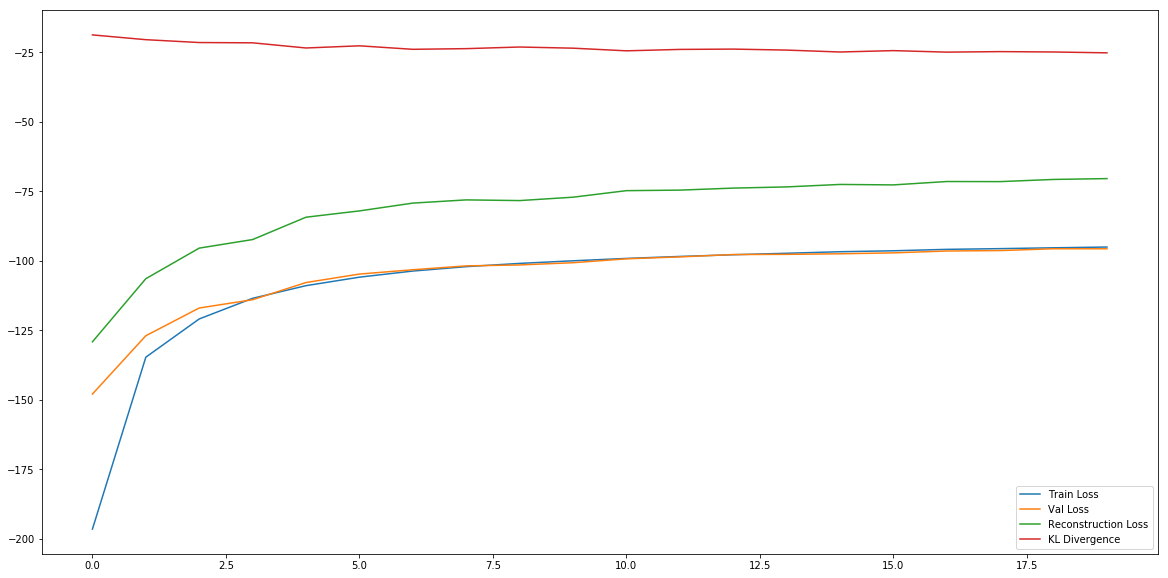

In [7]:
plt.figure(figsize=(20,10))
plt.plot(train_loss_log, label="Train Loss")
plt.plot(val_loss_log, label="Val Loss")
plt.plot(px_log, label="Reconstruction Loss")
plt.plot(kld_log, label="KL Divergence")
plt.legend()
plt.show()

In [8]:
[(i+1, x.tolist()) for i,x in enumerate(val_loss_log)]

[(1, -147.94198608398438),
 (2, -126.96601867675781),
 (3, -116.99447631835938),
 (4, -114.0157241821289),
 (5, -107.83516693115234),
 (6, -104.79103088378906),
 (7, -103.24099731445312),
 (8, -101.84760284423828),
 (9, -101.5099105834961),
 (10, -100.70785522460938),
 (11, -99.31204986572266),
 (12, -98.6128158569336),
 (13, -97.77041625976562),
 (14, -97.69871520996094),
 (15, -97.49876403808594),
 (16, -97.1672592163086),
 (17, -96.49642181396484),
 (18, -96.34209442138672),
 (19, -95.69031524658203),
 (20, -95.70156860351562)]

# IWAE

In [9]:
def q_2_1(model, x, k):
    """
    As discussed in the forum, we sample from x directly instead of using the provided z
    
    Yann Boutelier:
    1) Why do we take K samples of z as input if we take the model and the examples x_i? Couldn't we sample the K z_k 
    for each x_i directly in the function?
    
    chinwei: 1) yes you can do that. Not sure this requirement needs to be met so that it's easier to grade tho 
    Shawn Tan: 1) that's fine too. as long as it's all a self-contained function.
    """
    with torch.no_grad():
        x_reconstruction, z, mu, logvar = model(x, k)
        
        loss, logpx ,logpz ,logqz = model.compute_iwae_loss(x, x_reconstruction, z, mu, logvar)
        #In case we want to minimize it
        loss = -loss
        
    if k == 1:
        return torch.squeeze(logpx).mean(-1)
    else:
        return torch.squeeze(logpx).sum(0).mean(-1)

In [10]:
def q_2_2(model, x, k):
    """
    This function is similar to q_2_1, but it returns also a tuple of the other computed values. The loss is used
    for the comparison on Q2.2
    """
    with torch.no_grad():
        x_reconstruction, z, mu, logvar = model(x, k)
        
        loss, logpx ,logpz ,logqz = model.compute_iwae_loss(x, x_reconstruction, z, mu, logvar)
        #In case we want to minimize it
        loss = -loss
        
    if k == 1:
        return torch.squeeze(logpx).mean(-1), (loss, logpx ,logpz ,logqz)
    else:
        return torch.squeeze(logpx).sum(0).mean(-1), (loss, logpx ,logpz ,logqz)

## VALIDATION SET

In [11]:
k = 200
average_q2_IWAE_loss = 0
average_q2_vae_loss = 0

for batch, x in enumerate(valid_loader):
    x = Variable(x)
    inputs = x.to(device)

    logpx, (q2_loss, logpx_ ,logpz ,logqz) = q_2_2(iwae, inputs, k)
    q2_loss = -q2_loss
    average_q2_IWAE_loss += q2_loss.data.item()

    if batch%50 == 0:
        print("\t\tBatch:{} \tloss:{:.2f}".format(batch+1, average_q2_IWAE_loss/(batch+1)))


    x_reconstruction, z, mu, logvar = iwae(inputs)
    total_q2_vae_loss, px, kld = iwae.compute_vae_loss(inputs, x_reconstruction, mu, logvar, k=1)
    average_q2_vae_loss -= total_q2_vae_loss.data.item()

average_q2_IWAE_loss = average_q2_IWAE_loss/(batch+1)
average_q2_vae_loss = average_q2_vae_loss/(batch+1)
print("\nEstimation on k = {}: {}".format(k, average_q2_IWAE_loss))
print("Elbo:                 {}".format(average_q2_vae_loss))

		Batch:1 	loss:-87.30
		Batch:51 	loss:-90.09
		Batch:101 	loss:-90.32
		Batch:151 	loss:-90.43

Estimation on k = 200: -90.52226398249341
Elbo:                 -95.7800364889157


In [12]:
#Last batch is 16
logpx.size()

torch.Size([16])

## Test Set

In [13]:
k = 200
average_q2_IWAE_loss = 0
average_q2_vae_loss = 0

for batch, x in enumerate(test_loader):
    x = Variable(x)
    inputs = x.to(device)

    logpx, (q2_loss, logpx_ ,logpz ,logqz) = q_2_2(iwae, inputs, k)
    q2_loss = -q2_loss
    average_q2_IWAE_loss += q2_loss.data.item()

    if batch%50 == 0:
        print("\t\tBatch:{} \tloss:{:.2f}".format(batch+1, average_q2_IWAE_loss/(batch+1)))


    x_reconstruction, z, mu, logvar = iwae(inputs)
    total_q2_vae_loss, px, kld = iwae.compute_vae_loss(inputs, x_reconstruction, mu, logvar, k=1)
    average_q2_vae_loss -= total_q2_vae_loss.data.item()

average_q2_IWAE_loss = average_q2_IWAE_loss/(batch+1)
average_q2_vae_loss = average_q2_vae_loss/(batch+1)
print("\nEstimation on k = {}: {}".format(k, average_q2_IWAE_loss))
print("Elbo:                 {}".format(average_q2_vae_loss))

		Batch:1 	loss:-96.61
		Batch:51 	loss:-83.27
		Batch:101 	loss:-89.40
		Batch:151 	loss:-89.93

Estimation on k = 200: -89.7249104688122
Elbo:                 -94.83436212721904
